# IRASA

This notebook measures aperiodic activity using the 'irregular resampling auto-spectral analysis' (IRASA) algorithm.

IRASA does not explicitly consider signals with a knee, nor does it consider signals where there are central frequencies with some variance around them as in the setting of FOOOF. 

The purpose of this notebook is to test the robustness of IRASA to these deviations and to quantify the error in estimating $\chi$ as we test IRASA on various signals whose power spectrum deviates from a strict $1/f$ structure.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from neurodsp.sim import sim_powerlaw, sim_synaptic_current, sim_combined, sim_peak_oscillation
from neurodsp.spectral import compute_spectrum
from neurodsp.aperiodic import compute_irasa, fit_irasa

from fooof.plts import plot_spectrum, plot_spectra

/var/folders/59/8y2d5r257c77vzymnqs47x080000gn/T/ipykernel_35350/2904331950.py:10: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof.plts import plot_spectrum, plot_spectra


In [2]:
# Import custom code
import sys; from pathlib import Path
sys.path.append(str(Path('..').resolve()))

from apm.io import APMDB
from apm.run import run_sims, run_sims_load
from apm.methods import irasa, fit_irasa_exp, fit_irasa_knee
from apm.methods.settings import IRASA_PARAMS, IRASA_PARAMS_KNEE, FIT_F_RANGE, FIT_F_RANGE_LONG
from apm.plts.sims import plot_ap_sims, plot_pe_sims
from apm.plts.base import plot_lines
from apm.plts.settings import EXT, COLORS
from apm.sim.settings import (FS, EXP, EXPS, KNEES, FREQS, POWERS, BWS, N_SIMS,
                              SIM_PARAMS_AP, SIM_PARAMS_COMB, SIM_PARAMS_KNEE, SIM_PARAMS_PEAK)
from apm.sim.examples import SIG_AP, SIG_KN, SIG_OSC, SIG_COMB, SIG_PEAK
from apm.sim.sim import sim_combined_peak

## Settings

In [3]:
# Notebook settings
SAVE_FIG = False

In [4]:
# Plot 
PSD_PLT_KWARGS = {
    'log_freqs' : True,
    'log_powers' : True,
}

In [5]:
# Settings for saving figures
SAVE_FIG = True
EXT = '.pdf'
FIGPATH = APMDB().figs_path / '23_irasa'

In [6]:
# Settings for loading simulations
SIMPATH = APMDB().sims_path / 'time_series'

## IRASA

IRASA stands for irregularly resampled auto-spectral analysis. It assumes the signal model is an aperiodic component, namely a 1/f component, added with finitely many sinusoids. These sinusoids manifest themselves as discrete spikes in the power spectrum. IRASA computes the aperiodic component by appealing to the self-similar nature of signals whose power spectrum obeys a power law. Different from methods that fit the power spectrum, IRASA requires access to the time series data itself. By resampling the time series at non-integer rates, the spikes in the power spectrum corresponding to the sinusoids will be shifted in frequency by a quantity proportional to the resampling rate. However, self-similarity of the aperiodic component ensures that the power law decay remains the same across resamplings. Sinusoids are then averaged out across the power spectra of the resampled time series.

In [7]:
# Check the IRASA settings
print(IRASA_PARAMS)

{'fs': 500, 'f_range': (1, 50)}


In [8]:
# Check the IRASA settings - knee
IRASA_PARAMS_KNEE

{'fs': 500, 'f_range': (1, 75), 'fit_func': 'fit_irasa_knee'}

### IRASA on Example Signals

#### Powerlaw Signal

In [9]:
# Calculate IRASA and fit exponent
freqs, psd_ap, psd_pe = compute_irasa(SIG_AP, **IRASA_PARAMS)
fit_off, fit_exp = fit_irasa(freqs, psd_ap)

In [10]:
# Compute the full power spectrum
freqs_full, psd_full = compute_spectrum(SIG_AP, FS, f_range=FIT_F_RANGE)

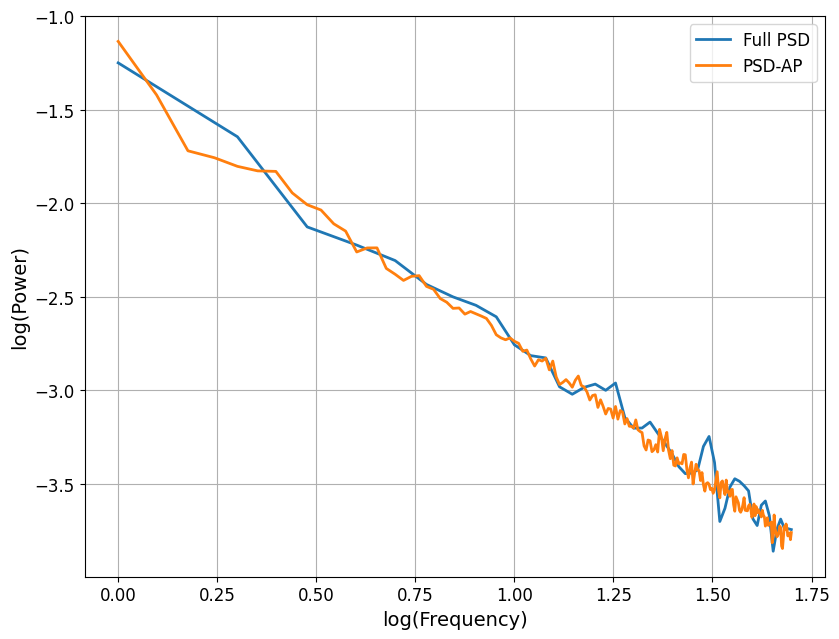

In [11]:
# Compare the full spectrum the IRASA separate aperiodic component
plot_spectra([freqs_full, freqs], [psd_full, psd_ap], 
             labels=['Full PSD', 'PSD-AP'], **PSD_PLT_KWARGS)

In [12]:
# Check the calculated value against ground truth
print('Measured Exponent:\t {:1.4f}'.format(fit_exp))
print('Expected Exponent:\t {:1.4f}'.format(EXP))

Measured Exponent:	 -1.4638
Expected Exponent:	 -1.5000


#### Combined Signal

In [13]:
# Calculate IRASA and fit exponent
freqs, psd_ap, psd_pe = compute_irasa(SIG_COMB, **IRASA_PARAMS)
fit_off, fit_exp  = fit_irasa(freqs, psd_ap)

In [14]:
# Compute the full power spectrum
freqs_full, psd_full = compute_spectrum(SIG_COMB, FS, f_range=FIT_F_RANGE)

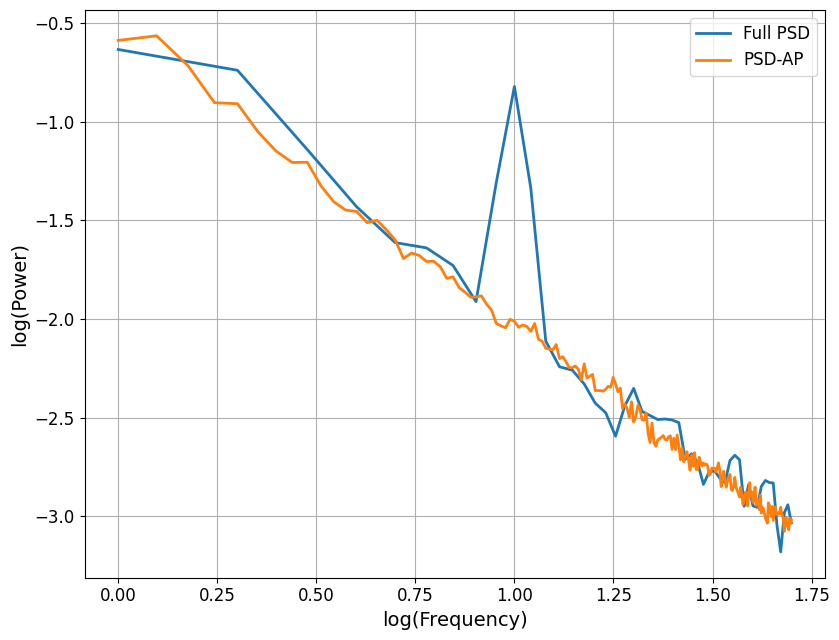

In [15]:
# Compare the full spectrum the IRASA separate aperiodic component
plot_spectra([freqs_full, freqs], [psd_full, psd_ap],
             labels=['Full PSD', 'PSD-AP'], **PSD_PLT_KWARGS,
             save_fig=SAVE_FIG, file_name='irasa_example' + EXT, file_path=FIGPATH)

In [16]:
# Check the calculated value against ground truth
print('Measured Exponent:\t {:1.4f}'.format(fit_exp))
print('Expected Exponent:\t {:1.4f}'.format(EXP))

Measured Exponent:	 -1.4833
Expected Exponent:	 -1.5000


#### Knee Signal

In [17]:
# Calculate IRASA and fit exponent
freqs, psd_ap, psd_pe = compute_irasa(SIG_KN, **IRASA_PARAMS)
fit_off, fit_exp  = fit_irasa(freqs, psd_ap)
fit_kn_off, fit_kn_knee, fit_kn_exp = fit_irasa_knee(freqs, psd_ap)

In [18]:
# Compute the full power spectrum
freqs_full, psd_full = compute_spectrum(SIG_KN, FS, f_range=FIT_F_RANGE_LONG)

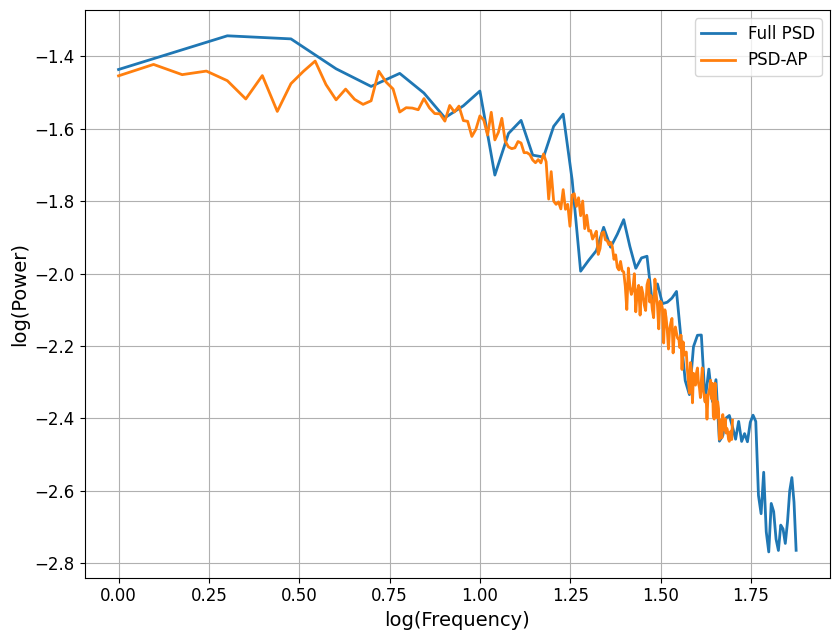

In [19]:
# Compare the full spectrum the IRASA separate aperiodic component
plot_spectra([freqs_full, freqs], [psd_full, psd_ap],
             labels=['Full PSD', 'PSD-AP'], **PSD_PLT_KWARGS)

In [20]:
# Check the calculated value against ground truth
print('Measured Exponent (fixed):\t {:1.4f}'.format(fit_exp))
print('Measured Exponent (knee):\t {:1.4f}'.format(fit_kn_exp))
print('Expected Exponent:\t\t {:1.4f}'.format(-2))

Measured Exponent (fixed):	 -0.7968
Measured Exponent (knee):	 -1.9378
Expected Exponent:		 -2.0000


#### Peak Bandwidth

In [21]:
# Calculate IRASA and fit exponent
freqs, psd_ap, psd_pe = compute_irasa(SIG_PEAK, **IRASA_PARAMS)
fit_off, fit_exp  = fit_irasa(freqs, psd_ap)

In [22]:
# Compute the full power spectrum
freqs_full, psd_full = compute_spectrum(SIG_PEAK, FS, f_range=FIT_F_RANGE)

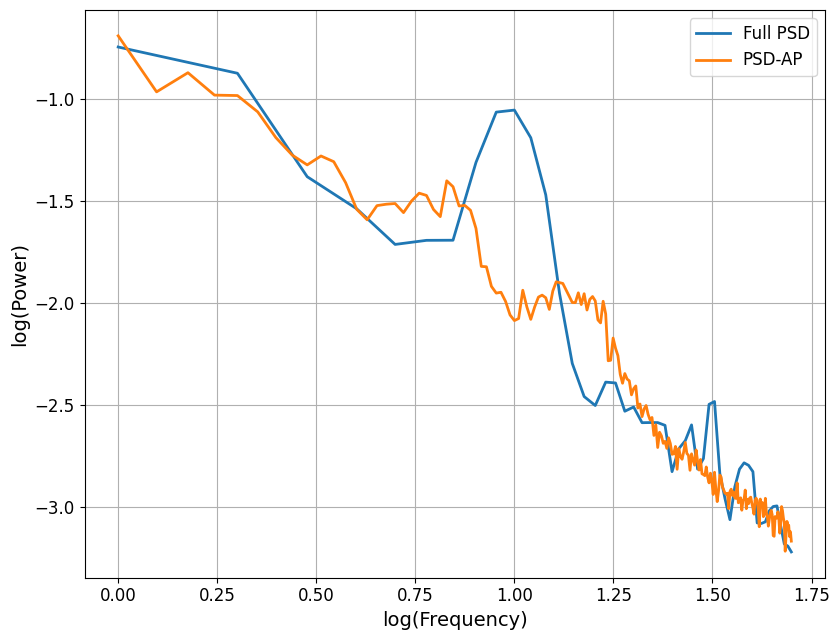

In [23]:
# Compare the full spectrum the IRASA separate aperiodic component
plot_spectra([freqs_full, freqs], [psd_full, psd_ap],
             labels=['Full PSD', 'PSD-AP'], **PSD_PLT_KWARGS)

In [24]:
# Check the calculated value against ground truth
print('Measured Exponent:\t {:1.4f}'.format(fit_exp))
print('Expected Exponent:\t {:1.4f}'.format(EXP))

Measured Exponent:	 -1.6194
Expected Exponent:	 -1.5000


## IRASA Simulation Tests

### Simulations: Aperiodic Variations

#### Aperiodic Exponent

In [25]:
# Run a set of simulations, calculating IRASA estimation across exponents
irasa_sims_exp, irasa_sims_exp_var = run_sims(\
    sim_powerlaw, SIM_PARAMS_AP, irasa, IRASA_PARAMS, 'update_exp', EXPS, N_SIMS)

#### Aperiodic Exponent (combined signal)

In [26]:
# Run a set of simulations, calculating IRASA estimation across exponents, with an oscillation
irasa_sims_comb, irasa_sims_comb_var = run_sims(\
    sim_combined, SIM_PARAMS_COMB, irasa, IRASA_PARAMS, 'update_comb_exp', EXPS, N_SIMS)

#### Visualize Results

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


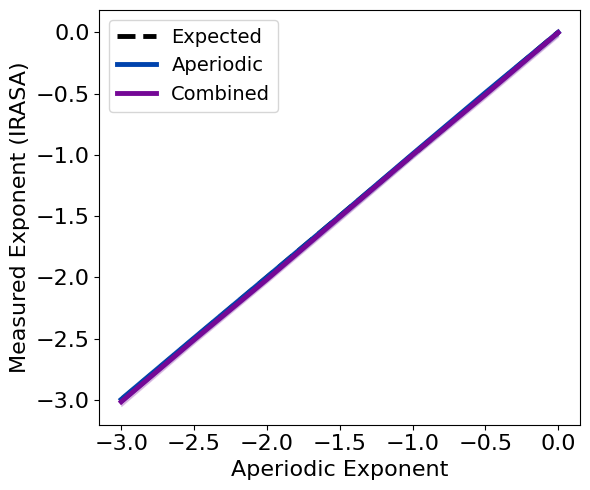

In [27]:
# Plot IRASA estimation across exponents, both with and without oscillation
plot_ap_sims(-1 * np.array(irasa_sims_exp), irasa_sims_exp_var,
             -1 * np.array(irasa_sims_comb), irasa_sims_comb_var, 
             'Measured Exponent (IRASA)', expected=EXPS,
             save_fig=SAVE_FIG, file_name='irasa_ap' + EXT, file_path=FIGPATH)

### Simulations: Periodic Variations

#### Oscillation Frequency

In [28]:
# Run a set of simulations, calculating IRASA across oscillation frequencies
irasa_sims_freq, irasa_sims_freq_var = run_sims(\
    sim_combined, SIM_PARAMS_COMB, irasa, IRASA_PARAMS, 'update_freq', FREQS, N_SIMS)

#### Oscillation Power

In [29]:
# Run a set of simulations, calculating IRASA across oscillation power
irasa_sims_pow, irasa_sims_pow_var = run_sims(\
    sim_combined, SIM_PARAMS_COMB, irasa, IRASA_PARAMS, 'update_pow', POWERS, N_SIMS)

#### Visualize Results

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


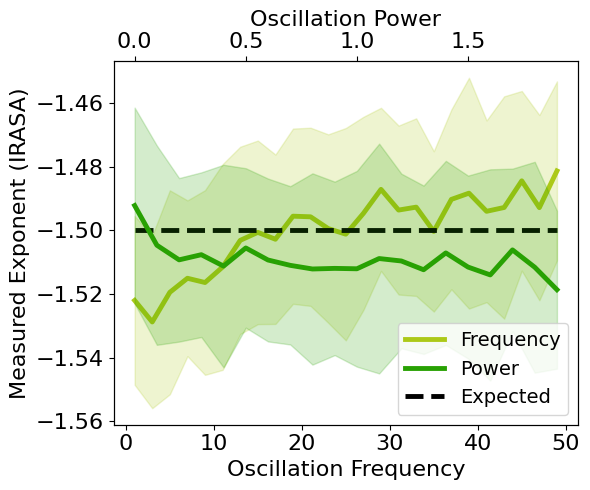

In [30]:
# Plot effect of oscillation variation on DFA exponent
plot_pe_sims(-1 * np.array(irasa_sims_freq), irasa_sims_freq_var,
             -1 * np.array(irasa_sims_pow), irasa_sims_pow_var,
             'Measured Exponent (IRASA)', expected=[-1.5]*len(FREQS),
             save_fig=SAVE_FIG, file_name='irasa_pe' + EXT, file_path=FIGPATH)

## Simulations: Knee Variations

In [31]:
# Run a set of simulations, calculating IRASA estimation across different timescales
irasa_sims_knee_lin, irasa_sims_knee_lin_var = run_sims(\
    sim_synaptic_current, SIM_PARAMS_KNEE, irasa, IRASA_PARAMS, 'update_knee', KNEES, N_SIMS)

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


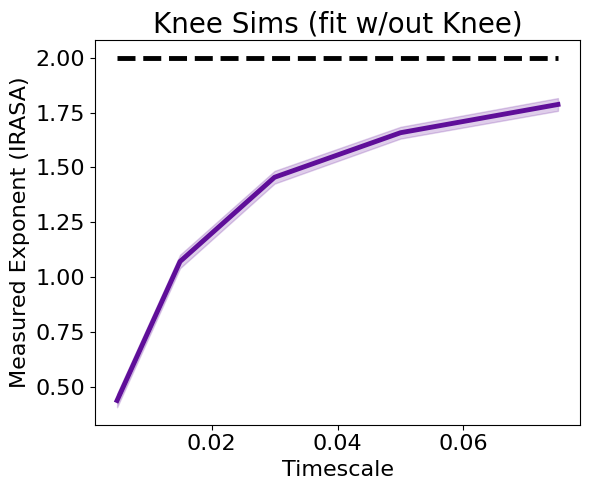

In [32]:
# Plot the estimated exponent across different timescales (estimated without a knee)
plot_lines(KNEES, irasa_sims_knee_lin, irasa_sims_knee_lin_var, color=COLORS['KN'], figsize=(6, 5))
plot_lines(KNEES, [2.0] * len(KNEES), color='black', linestyle='--', ax=plt.gca())
plot_lines(title='Knee Sims (fit w/out Knee)')
plot_lines(xlabel='Timescale', ylabel='Measured Exponent (IRASA)')
plot_lines(save_fig=SAVE_FIG, file_name='irasa_knee_lin' + EXT, file_path=FIGPATH)

In [33]:
# Run a set of simulations, calculating IRASA estimation across different timescales
irasa_sims_knee, irasa_sims_knee_var = run_sims(\
    sim_synaptic_current, SIM_PARAMS_KNEE, irasa, IRASA_PARAMS_KNEE, 'update_knee', KNEES, N_SIMS)

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


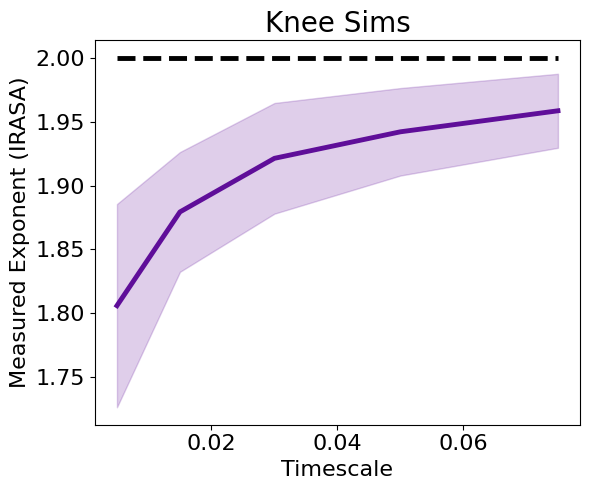

In [34]:
# Plot the estimated exponent across different timescales (estimated with a knee)
plot_lines(KNEES, irasa_sims_knee, irasa_sims_knee_var, color=COLORS['KN'], figsize=(6, 5))
plot_lines(KNEES, [2.0] * len(KNEES), color='black', linestyle='--', ax=plt.gca())
plot_lines(title='Knee Sims')
plot_lines(xlabel='Timescale', ylabel='Measured Exponent (IRASA)')
plot_lines(save_fig=SAVE_FIG, file_name='irasa_knee' + EXT, file_path=FIGPATH)

## Simulations: Bandwidth Variations

In [35]:
# irasa_sims_bw, irasa_sims_bw_var = run_sims(\
#     sim_combined_peak, SIM_PARAMS_PEAK, irasa, IRASA_PARAMS, 'update_peak_bw', BWS, N_SIMS)

In [36]:
# Run a set of simulations, calculating IRASA estimate across peak bandwidth (sims from file)
irasa_sims_bw, irasa_sims_bw_var = run_sims_load(\
    SIMPATH / 'ts_sims_comb_bw', irasa, IRASA_PARAMS)

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


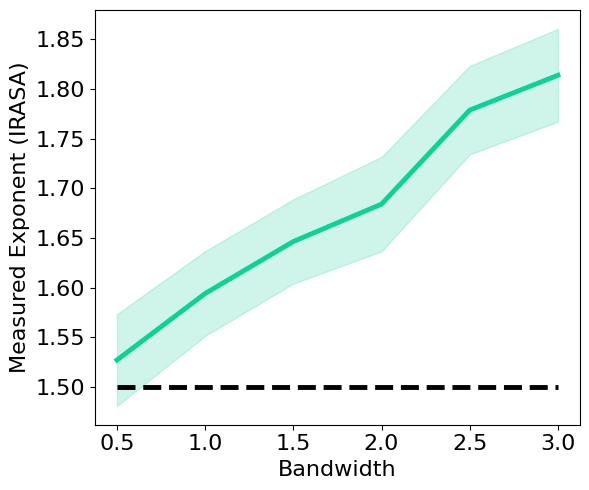

In [37]:
# Plot the estimated exponent across different timescales (estimated with a knee)
plot_lines(BWS, irasa_sims_bw, irasa_sims_bw_var, color=COLORS['BW'], figsize=(6, 5))
plot_lines(BWS, [-EXP] * len(BWS), color='black', linestyle='--', ax=plt.gca())
#plot_lines(title='Bandwidth Sims')
plot_lines(xlabel='Bandwidth', ylabel='Measured Exponent (IRASA)')
plot_lines(save_fig=SAVE_FIG, file_name='irasa_bw' + EXT, file_path=FIGPATH)

## Conclusions

Overall, we can see the following patterns in these simulations:

IRASA:
- When the data is a true 1/f, IRASA is highly accurate at estimating aperiodic exponent
- With 1/f aperiodic activity, IRASA exponent estimations are robust to oscillation frequency and power